# Ejercicio k-Nearest Neighbor

## App Reviews
En este ejercicio vas a trabajar con una base de datos de reviews de una aplicación. Entre los datos podemos encontrar el texto de la review, las estrellas, así como el sentimiento del comentario (si es algo bueno o malo).

El objetivo es montar un algoritmo de clasificación que prediga el rating, en función del sentimiento del comentario y la cantidad de palabras empleadas en el mismo. Para ello tendrás que utilizar un algoritmo de tipo KNN.

### Importamos las librerías que vamos a utilizar

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

## Leemos nuestro archivo de entrada `reviews_sentiment`

In [49]:
pd.set_option("max_colwidth", 200)

In [50]:
df = pd.read_csv("data/reviews_sentiment.csv", sep=";")
df

,Review Title,Review Text,wordcount,titleSentiment,textSentiment,Star Rating,sentimentValue
0,Sin conexión,"Hola desde hace algo más de un mes me pone sin conexión y no sale nada, antes me funcionaba correctamente.",23,negative,negative,1,-0.486389
1,faltan cosas,Han mejorado la apariencia pero no,20,negative,negative,1,-0.586187
2,Es muy buena lo recomiendo,Andres e puto amoooo,4,NaN,negative,1,-0.602240
3,Version antigua,Me gustana mas la version anterior esta es mas complicada de usar hay gente cambiandosevpor esevmotivo gracias,17,NaN,negative,1,-0.616271
4,Esta bien,Sin ser la biblia.... Esta bien,6,negative,negative,1,-0.651784
...,...,...,...,...,...,...,...
252,Muy buena aplicacion,Muy buena genial,3,positive,positive,5,2.814818
253,Buena,Genial,1,positive,positive,5,2.924393
254,Wuau,Genial,1,positive,positive,5,2.924393
255,Muy buena,Genial,1,positive,positive,5,2.924393


Para facilitar el ejercicio, las columnas que utilizaremos serán: wordcount con la cantidad de palabras utilizadas y sentimentValue con un valor entre -4 y 4 que indica si el comentario fue valorado como positivo o negativo

Nuestras etiquetas, serán las estrellas que dieron los usuarios a la app, que son valores discretos del 1 al 5

## Rápidas visualizaciones y análisis
Al menos realiza un análisis univariante y representa la distribución del rating. Realiza otras visualizaciones para ver la relación de tus datos.

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Review Title    257 non-null    object 
 1   Review Text     257 non-null    object 
 2   wordcount       257 non-null    int64  
 3   titleSentiment  231 non-null    object 
 4   textSentiment   257 non-null    object 
 5   Star Rating     257 non-null    int64  
 6   sentimentValue  257 non-null    float64
dtypes: float64(1), int64(2), object(4)
memory usage: 14.2+ KB


In [52]:
df.describe()

,wordcount,Star Rating,sentimentValue
count,257.000000,257.000000,257.000000
mean,11.501946,3.420233,0.383849
std,13.159812,1.409531,0.897987
min,1.000000,1.000000,-2.276469
25%,3.000000,3.000000,-0.108144
50%,7.000000,3.000000,0.264091
75%,16.000000,5.000000,0.808384
max,103.000000,5.000000,3.264579


In [53]:
# Cuántas reviews hay por cada calificación
df['Star Rating'].value_counts()

Star Rating
5    88
3    78
1    37
4    30
2    24
Name: count, dtype: int64

In [54]:
# Cuántas reviews hay por cada sentimiento
df['textSentiment'].value_counts()


textSentiment
positive    211
negative     46
Name: count, dtype: int64

In [55]:
df.isnull().sum()


Review Title       0
Review Text        0
wordcount          0
titleSentiment    26
textSentiment      0
Star Rating        0
sentimentValue     0
dtype: int64

In [56]:
# Seleccionamos las columnas 'wordcount', 'sentimentValue' y 'Star Rating' del DataFrame df
# Estas son las variables que queremos analizar para ver cómo se correlacionan entre ellas
df[['wordcount', 'sentimentValue', 'Star Rating']]


,wordcount,sentimentValue,Star Rating
0,23,-0.486389,1
1,20,-0.586187,1
2,4,-0.602240,1
3,17,-0.616271,1
4,6,-0.651784,1
...,...,...,...
252,3,2.814818,5
253,1,2.924393,5
254,1,2.924393,5
255,1,2.924393,5


Text(0.5, 1.0, 'Matriz de correlación')

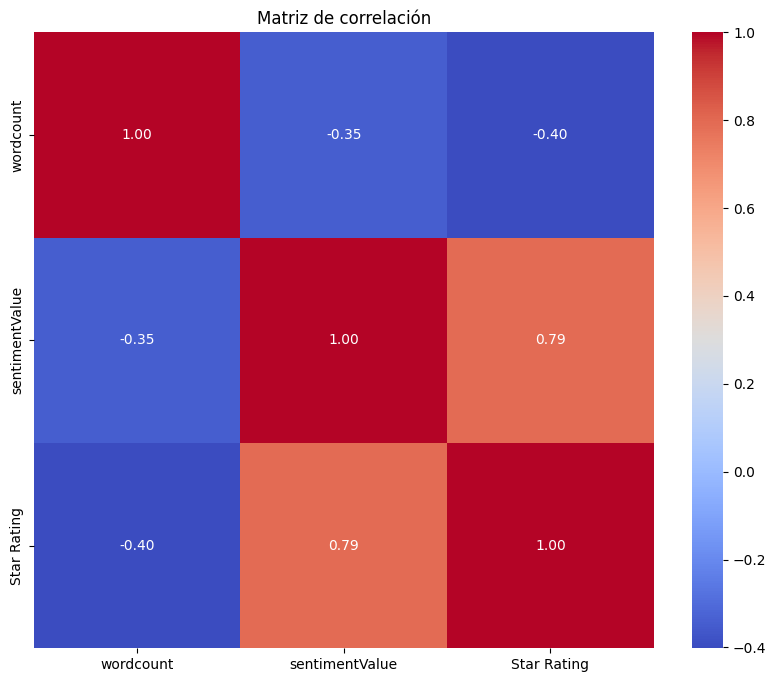

In [57]:
# matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df[['wordcount', 'sentimentValue', 'Star Rating']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')

## Preparamos el dataset
Divide en train/test y escala las features en el rango [0, 1].

In [58]:
# Features y etiquetas
X = df[['wordcount', 'sentimentValue']]  # Selección de las características que el modelo utilizará para predecir
y = df['Star Rating']  # La etiqueta es 'Star Rating', que es lo que queremos predecir

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
# Se divide el conjunto de datos en entrenamiento (80%) y prueba (20%) con una semilla fija para reproducibilidad

# Escalado
scaler = MinMaxScaler()  # Creamos un objeto MinMaxScaler para normalizar las características en el rango [0, 1]
X_train_scaled = scaler.fit_transform(X_train)  # Ajustamos el escalador y transformamos los datos de entrenamiento
X_test_scaled = scaler.transform(X_test)  # Aplicamos la misma transformación a los datos de prueba (sin ajustar el escalador)



## Creamos el Modelo
Entrena con un KNN y evalúa el error en train y en test

In [59]:
# Preparamos los datos
X = df[['wordcount', 'sentimentValue']]  # Seleccionamos las características 'wordcount' y 'sentimentValue' para la predicción
y = df['Star Rating']  # La etiqueta que queremos predecir es 'Star Rating'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Dividimos los datos en entrenamiento y prueba (80%/20%)

# Escalado
scaler = MinMaxScaler()  # Creamos un escalador para normalizar las características a un rango entre 0 y 1
X_train_scaled = scaler.fit_transform(X_train)  # Ajustamos y transformamos los datos de entrenamiento
X_test_scaled = scaler.transform(X_test)  # Transformamos los datos de prueba con el mismo escalador

# Búsqueda del mejor k
train_errors = []  # Lista para almacenar los errores en el conjunto de entrenamiento
test_errors = []  # Lista para almacenar los errores en el conjunto de prueba
k_values = range(1, 21)  # Definimos el rango de valores de k, de 1 a 20

# Iteramos sobre los diferentes valores de k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)  # Creamos el clasificador KNN con el valor de k actual
    knn.fit(X_train_scaled, y_train)  # Entrenamos el modelo con los datos de entrenamiento escalados
    
    train_acc = accuracy_score(y_train, knn.predict(X_train_scaled))  # Calculamos la precisión en el conjunto de entrenamiento
    test_acc = accuracy_score(y_test, knn.predict(X_test_scaled))  # Calculamos la precisión en el conjunto de prueba
    
    train_errors.append(1 - train_acc)  # Guardamos el error de entrenamiento (1 - precisión)
    test_errors.append(1 - test_acc)  # Guardamos el error de prueba (1 - precisión)




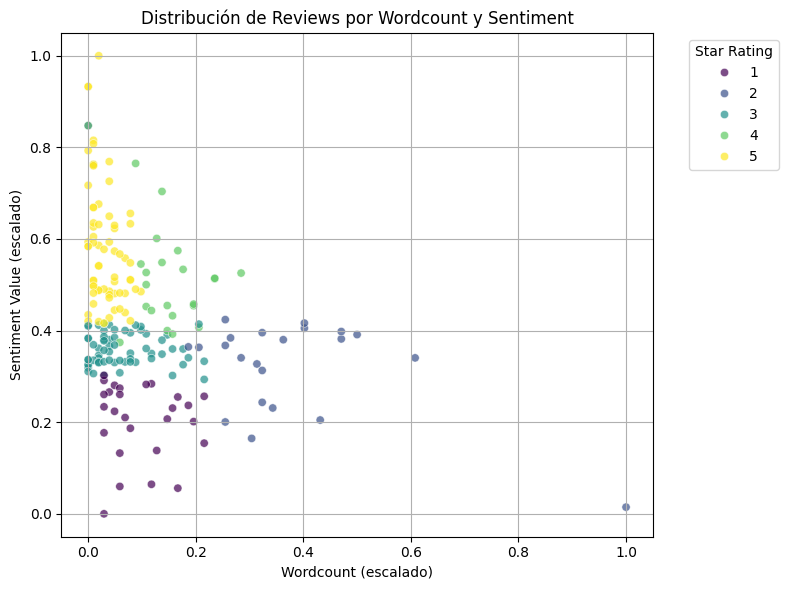

In [60]:
# Scatter plot de los datos escalados
plt.figure(figsize=(8, 6))  # Se establece el tamaño de la figura (8x6 pulgadas)

sns.scatterplot(
    x=X_train_scaled[:, 0],  # wordcount escalado (primera columna de X_train_scaled)
    y=X_train_scaled[:, 1],  # sentimentValue escalado (segunda columna de X_train_scaled)
    hue=y_train,  # Colorea los puntos según el valor de 'Star Rating' en el conjunto de entrenamiento
    palette='viridis',  # Usa la paleta de colores 'viridis' para el gráfico
    alpha=0.7  # Ajusta la transparencia de los puntos, donde 1 es completamente opaco y 0 es completamente transparente
)

plt.title('Distribución de Reviews por Wordcount y Sentiment')  # Título del gráfico
plt.xlabel('Wordcount (escalado)')  # Etiqueta del eje X
plt.ylabel('Sentiment Value (escalado)')  # Etiqueta del eje Y
plt.legend(title='Star Rating', bbox_to_anchor=(1.05, 1), loc='upper left')  # Leyenda fuera del gráfico, a la derecha
plt.grid(True)  # Muestra una cuadrícula en el gráfico para mejor visualización
plt.tight_layout()  # Ajusta los márgenes para que no se solapen los elementos del gráfico
plt.show()  # Muestra el gráfico en pantalla


## Evalúa tu modelo

Accuracy en test: 0.79


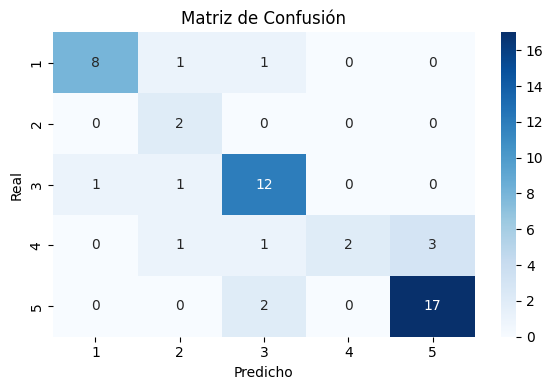

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.89      0.80      0.84        10
           2       0.40      1.00      0.57         2
           3       0.75      0.86      0.80        14
           4       1.00      0.29      0.44         7
           5       0.85      0.89      0.87        19

    accuracy                           0.79        52
   macro avg       0.78      0.77      0.71        52
weighted avg       0.83      0.79      0.78        52



In [61]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predecimos en test
y_pred = knn.predict(X_test_scaled)  # Realizamos predicciones sobre el conjunto de prueba (X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)  # Calculamos la precisión del modelo (porcentaje de predicciones correctas)
print(f"Accuracy en test: {accuracy:.2f}")  # Imprimimos la precisión en el conjunto de prueba

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)  # Calculamos la matriz de confusión

# Graficamos la matriz de confusión
plt.figure(figsize=(6, 4))  # Definimos el tamaño de la figura del gráfico
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  # Usamos un heatmap para visualizar la matriz de confusión
            xticklabels=knn.classes_, yticklabels=knn.classes_)  # Etiquetas para las clases (eje x y eje y)
plt.xlabel('Predicho')  # Etiqueta del eje X (Predicción)
plt.ylabel('Real')  # Etiqueta del eje Y (Valores reales)
plt.title('Matriz de Confusión')  # Título del gráfico
plt.tight_layout()  # Ajusta los márgenes para que el gráfico no se solape
plt.show()  # Muestra el gráfico en pantalla

print("Reporte de Clasificación:")  # Imprime un encabezado
print(classification_report(y_test, y_pred))  # Muestra el reporte de clasificación con métricas como precisión, recall, f1-score


- Clases individuales (Star Rating):
- Precision: qué porcentaje de las predicciones para esa clase fueron correctas.
- Recall: qué porcentaje de los elementos reales de esa clase fueron correctamente identificados.
- F1-score: balance entre precision y recall (una especie de promedio armónico).
- Support: cuántas muestras reales había de esa clase.
------
- Todas las predicciones como "1" fueron correctas (precision perfecta), pero solo identificó 5/6 casos reales.
- 2. Rendimiento perfecto: identificó todos los casos reales y sin errores.
- 3. Predijo todas las clases 3 correctamente (recall = 1.0), pero también predijo clase 3 donde no lo era (precision más baja).
- 4. Todas las predicciones como 4 fueron correctas, pero solo identificó 2 de los 5 casos reales (recall bajo).
- 5. Buen rendimiento general, con pequeñas fallas tanto en precision como en recall.
-----
- Métricas globales
- accuracy: 0.79. El 79% de las predicciones fueron correctas sobre el total de muestras de prueba.
- macro avg. Promedio simple entre las clases (sin tener en cuenta cuántos ejemplos tiene cada una).
- Aquí se ve que el recall más bajo (clase 4) baja el promedio.
- weighted avg. Promedio ponderado según el número de ejemplos de cada clase.

## ¿Cómo obtener el mejor valor de k? Crea y evalúa nuevos modelos
¿Qué valor de k maximiza el accuracy? Representa todas las iteraciones en un scatterplot -> k vs accuracy

In [67]:
import matplotlib.pyplot as plt  # Importa la librería para gráficos
from sklearn.neighbors import KNeighborsClassifier  # Importa el clasificador KNN
from sklearn.metrics import accuracy_score  # Importa la función para calcular la precisión (accuracy)

# Rango de k a probar
k_range = range(1, 21)  # Define el rango de valores de k que se van a probar, de 1 a 20
accuracies = []  # Lista para almacenar la precisión para cada valor de k

# Probar cada valor de k
for k in k_range:  # Itera sobre el rango de valores de k
    knn = KNeighborsClassifier(n_neighbors=k)  # Crea una instancia del clasificador KNN con el valor de k actual
    knn.fit(X_train_scaled, y_train)  # Entrena el modelo usando los datos de entrenamiento escalados (X_train_scaled y y_train)
    y_pred = knn.predict(X_test_scaled)  # Realiza predicciones sobre el conjunto de prueba escalado (X_test_scaled)
    acc = accuracy_score(y_test, y_pred)  # Calcula la precisión comparando las predicciones con las etiquetas reales (y_test)
    accuracies.append(acc)  # Guarda la precisión obtenida en la lista accuracies

# Encontrar el mejor k
best_k = k_range[accuracies.index(max(accuracies))]  # Encuentra el valor de k que produce la mejor precisión
best_acc = max(accuracies)  # Obtiene la mejor precisión
print(f"El mejor valor de k es {best_k} con un accuracy de {best_acc:.2f}")  # Imprime el mejor valor de k y su precisión


El mejor valor de k es 2 con un accuracy de 0.85


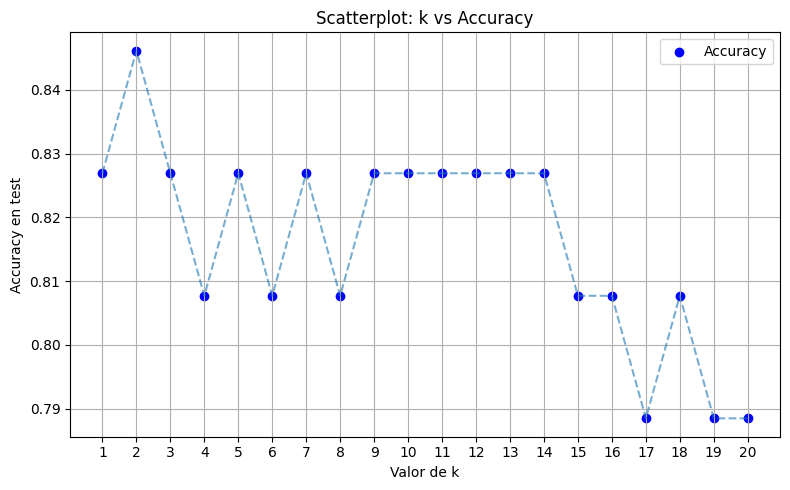

In [68]:
# Scatterplot de k vs accuracy
plt.figure(figsize=(8, 5))  # Crea una figura para el gráfico con un tamaño de 8x5 pulgadas
plt.scatter(k_range, accuracies, color='blue', label='Accuracy')  # Dibuja un scatterplot con k en el eje x y las precisiones en el eje y
plt.plot(k_range, accuracies, linestyle='--', alpha=0.6)  # Dibuja una línea punteada para mostrar la tendencia de accuracy con k, con una opacidad de 0.6

plt.xlabel('Valor de k')  # Etiqueta para el eje X
plt.ylabel('Accuracy en test')  # Etiqueta para el eje Y
plt.title('Scatterplot: k vs Accuracy')  # Título del gráfico
plt.xticks(k_range)  # Coloca los valores de k como marcas en el eje X
plt.grid(True)  # Activa la cuadrícula en el gráfico para mejor visibilidad
plt.legend()  # Muestra la leyenda para el gráfico
plt.tight_layout()  # Ajusta el diseño para que todo el contenido encaje bien en el gráfico
plt.show()  # Muestra el gráfico


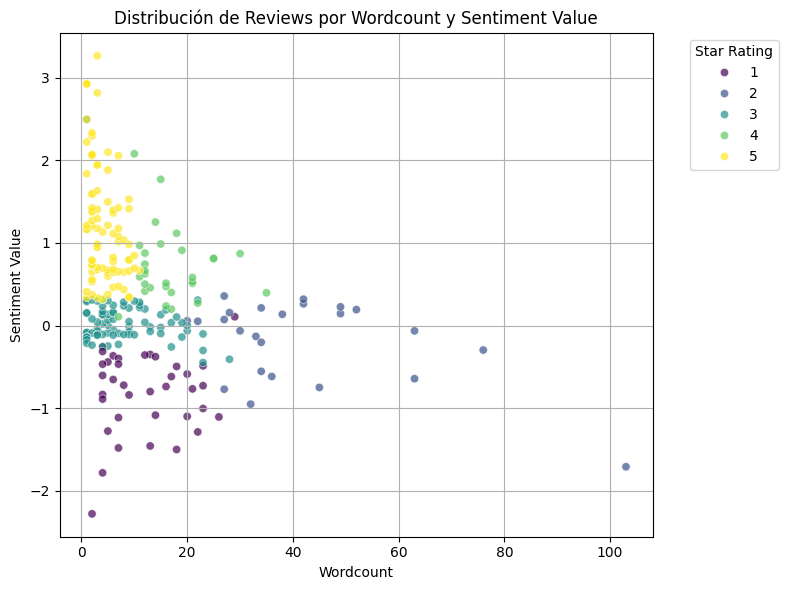

In [69]:
# Scatterplot de wordcount vs sentimentValue con las etiquetas Star Rating
plt.figure(figsize=(8, 6))  # Crea una figura para el gráfico con un tamaño de 8x6 pulgadas

# Dibuja el scatterplot utilizando seaborn
sns.scatterplot(
    x=df['wordcount'],  # La variable en el eje X será 'wordcount' (número de palabras en la reseña)
    y=df['sentimentValue'],  # La variable en el eje Y será 'sentimentValue' (valor de sentimiento de la reseña)
    hue=df['Star Rating'],  # El color de los puntos se basará en la columna 'Star Rating' (etiquetas de valoración)
    palette='viridis',  # Se utiliza la paleta de colores 'viridis' para distinguir las diferentes valoraciones
    alpha=0.7  # Establece la transparencia de los puntos a 0.7 (un valor entre 0 y 1)
)

# Títulos y etiquetas
plt.title('Distribución de Reviews por Wordcount y Sentiment Value')  # Título del gráfico
plt.xlabel('Wordcount')  # Etiqueta para el eje X (número de palabras en la reseña)
plt.ylabel('Sentiment Value')  # Etiqueta para el eje Y (valor de sentimiento de la reseña)

# Leyenda y configuración
plt.legend(title='Star Rating', bbox_to_anchor=(1.05, 1), loc='upper left')  # Coloca la leyenda fuera del gráfico (en la parte superior izquierda)
plt.grid(True)  # Activa la cuadrícula para mejorar la visibilidad
plt.tight_layout()  # Ajusta automáticamente los márgenes para que todo se vea bien en el gráfico
plt.show()  # Muestra el gráfico en pantalla


## Predice con nuevos datos.
Ejemplo: supongamos que nos llega una review de 5 palabras y sentimiento 1

In [70]:
# Nuevo dato: 5 palabras y sentimiento 1
nuevo_dato = np.array([[5, 1]])  # Se crea un nuevo dato con 5 palabras y un sentimiento de 1 (positivo)

# Escalamos con el mismo scaler usado en el entrenamiento
nuevo_dato_escalado = scaler.transform(nuevo_dato)  # Escalamos el nuevo dato utilizando el mismo scaler que se usó durante el entrenamiento

# Predecimos con el mejor modelo (ya entrenado con best_k)
mejor_knn = KNeighborsClassifier(n_neighbors=best_k)  # Creamos una nueva instancia del clasificador KNN con el mejor k encontrado (best_k)
mejor_knn.fit(X_train_scaled, y_train)  # Entrenamos el clasificador KNN usando los datos escalados de entrenamiento
prediccion = mejor_knn.predict(nuevo_dato_escalado)  # Hacemos la predicción para el nuevo dato escalado

# Imprimimos la predicción
print(f"La predicción para una review de 5 palabras y sentimiento 1 es: {prediccion[0]} estrellas")  # Imprimimos la predicción de la clase (número de estrellas) para el nuevo dato


La predicción para una review de 5 palabras y sentimiento 1 es: 5 estrellas


c:\Users\nsara\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Correlación entre Longitud de la Review y Calificación')

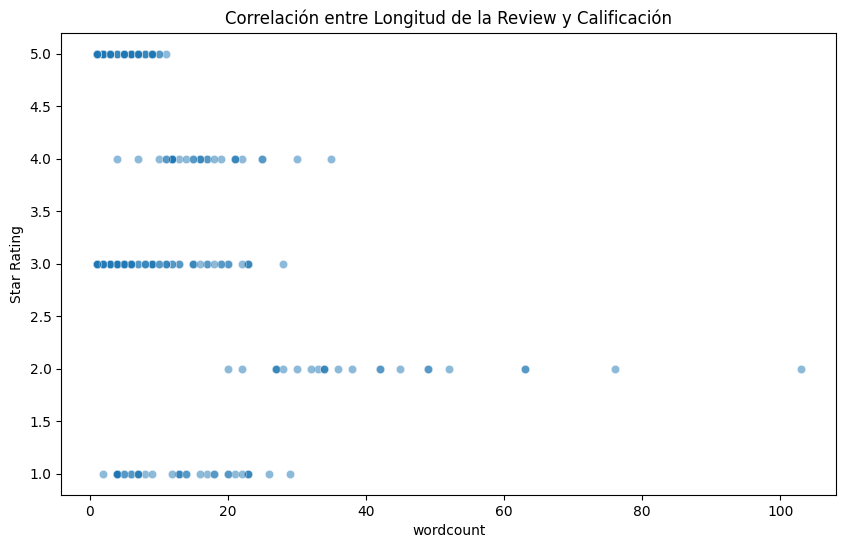

In [ ]:
# Correlación entre la longitud de la review y la calificación
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['wordcount'], y=df['Star Rating'], alpha=0.5)
plt.title('Correlación entre Longitud de la Review y Calificación')